# FIFA World Cup Data Analysis and Prediction
This notebook performs exploratory data analysis (EDA) and builds a machine learning model to predict future FIFA World Cup winners.


## Library Installation and Imports
Install and import the necessary libraries for data manipulation, visualization, and machine learning.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import cufflinks as cf
import plotly.graph_objects as go
import os
from plotly.offline import iplot, init_notebook_mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Initialize Plotly for offline/notebook use
init_notebook_mode(connected=True)
cf.go_offline()


## Data Loading
Use a flexible function to search for the dataset in various potential directories.


In [36]:
def load_worldcup_data():
    """
    Flexible file loader that checks multiple possible locations.
    """
    possible_paths = [
        '.', 
        'data',
        'fifa-world-cup',
        '../data',
        os.path.join(os.getcwd(), 'fifa-world-cup')
    ]
    
    for path in possible_paths:
        try:
            players = pd.read_csv(
                os.path.join(path, "WorldCupPlayers.csv"),
            )
            matches = pd.read_csv(
                os.path.join(path, "WorldCupMatches.csv"),
            )
            world_cup = pd.read_csv(
                os.path.join(path, "WorldCups.csv"),
            )
            print(f"Data successfully loaded from: {path}")
            return players, matches, world_cup
        except FileNotFoundError:
            continue
    
    # Error Handling
    print("ERROR: Could not find data files in these locations:")
    for path in possible_paths:
        print(f"- {os.path.join(path, 'WorldCupPlayers.csv')}")
    print("\nCurrent directory contents:")
    print(os.listdir('.'))
    raise FileNotFoundError("Missing World Cup data files")


# Load data
players, matches, world_cup = load_worldcup_data()


Data successfully loaded from: .


## Data Cleaning
Fix malformed names and unify naming conventions across all datasets.


In [37]:
# Drop any rows in matches where Year is NaN
matches.dropna(subset=['Year'], inplace=True)

# Fix corrupted names (eg. HTML remnants like 'rn">') by identifying them and replacing
names_with_html = matches[matches['Home Team Name'].str.contains('rn">', na=False)]['Home Team Name'].value_counts()
wrong = list(names_with_html.index)
correct = [name.split('>')[1] for name in wrong]

# Also fix some old names explicitly
old_name = ['Germany FR', 'Maracan� - Est�dio Jornalista M�rio Filho', 'Estadio do Maracana']
new_name = ['Germany',      'Maracan Stadium',                 'Maracan Stadium']

wrong += old_name
correct += new_name

# Apply replacements across all three DataFrames
for wr, corr in zip(wrong, correct):
    world_cup.replace(wr, corr, inplace=True)
    matches.replace(wr, corr, inplace=True)
    players.replace(wr, corr, inplace=True)

# Verify that no more 'rn">' strings remain
names_after = matches[matches['Home Team Name'].str.contains('rn">', na=False)]['Home Team Name'].value_counts()
print("Remaining corrupt names:", names_after) 


Remaining corrupt names: Series([], Name: count, dtype: int64)


## Podium Analysis
Count how many times each country has won, placed second, or third.


In [38]:
winner = world_cup['Winner'].value_counts()
runnerup = world_cup['Runners-Up'].value_counts()
third = world_cup['Third'].value_counts()

teams = pd.concat([winner, runnerup, third], axis=1).fillna(0).astype(int)
teams.columns = ['Wins', 'Runners-Up', 'Third Place']
teams

teams.iplot(
    kind='bar',
    xTitle='Teams',
    yTitle='Count',
    title='FIFA World Cup Podium Finishes'
)


## Goals Scored by Country
Calculate and plot the total goals each country has scored (home and away combined).


In [39]:
home_goals = matches[['Home Team Name', 'Home Team Goals']].dropna()
away_goals = matches[['Away Team Name', 'Away Team Goals']].dropna()

home_goals.columns = ['Country', 'Goals']
away_goals.columns = ['Country', 'Goals']

goals = pd.concat([home_goals, away_goals], ignore_index=True)
goals = goals.groupby('Country')['Goals'].sum().sort_values(ascending=False)

# Top 20 countries by goals
goals[:20].iplot(
    kind='bar',
    xTitle='Country',
    yTitle='Goals',
    title='Top 20 Countries by Total World Cup Goals'
)


## Attendance Analysis
Visualize how attendance per tournament year has changed over time.


/var/folders/82/3cb3k0x17r5bvwln9n1r4hh40000gn/T/ipykernel_26707/305784057.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



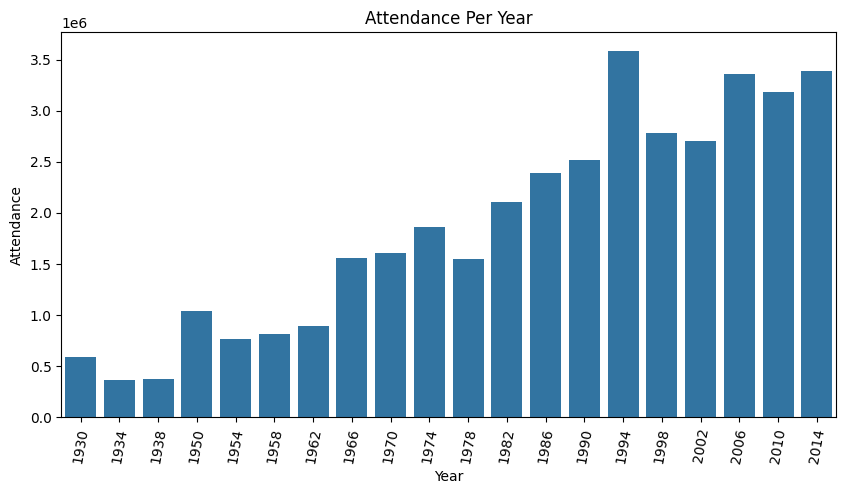

In [40]:
# First, clean the Attendance column (remove dots used as thousands separators)
world_cup['Attendance'] = world_cup['Attendance'].str.replace(".", "", regex=False).astype(float)

# Attendance Per Year
plt.figure(figsize=(10, 5))
sns.despine(right=True)
g = sns.barplot(x='Year', y='Attendance', data=world_cup)
g.set_xticklabels(g.get_xticklabels(), rotation=80)
g.set_title('Attendance Per Year')
plt.show()

## Tournament Statistics Over Time
Explore how the number of qualified teams, goals scored, and matches played have evolved through the years.


/var/folders/82/3cb3k0x17r5bvwln9n1r4hh40000gn/T/ipykernel_26707/2348484345.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



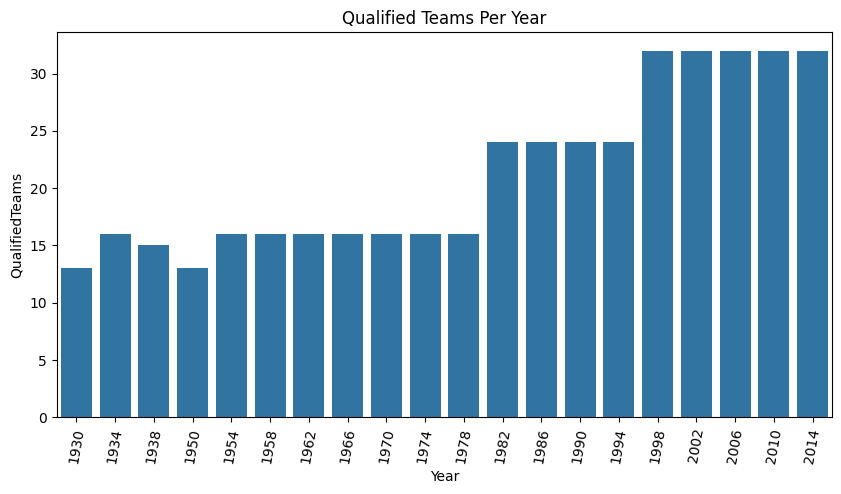

In [41]:
# Qualified Teams Per Year
plt.figure(figsize=(10, 5))
sns.despine(right=True)
g = sns.barplot(x='Year', y='QualifiedTeams', data=world_cup)
g.set_xticklabels(g.get_xticklabels(), rotation=80)
g.set_title('Qualified Teams Per Year')
plt.show()


/var/folders/82/3cb3k0x17r5bvwln9n1r4hh40000gn/T/ipykernel_26707/3121649384.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



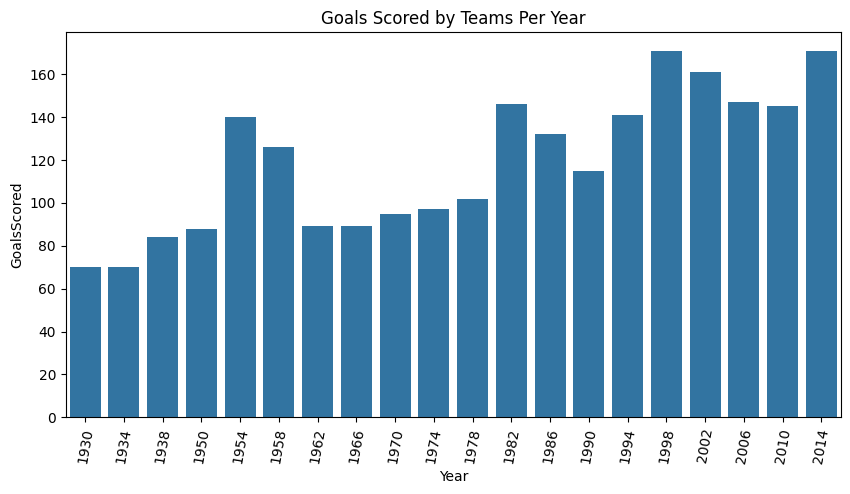

In [42]:
# Goals Scored by Teams Per Year
plt.figure(figsize=(10, 5))
sns.despine(right=True)
g = sns.barplot(x='Year', y='GoalsScored', data=world_cup)
g.set_xticklabels(g.get_xticklabels(), rotation=80)
g.set_title('Goals Scored by Teams Per Year')
plt.show()

/var/folders/82/3cb3k0x17r5bvwln9n1r4hh40000gn/T/ipykernel_26707/2204654749.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



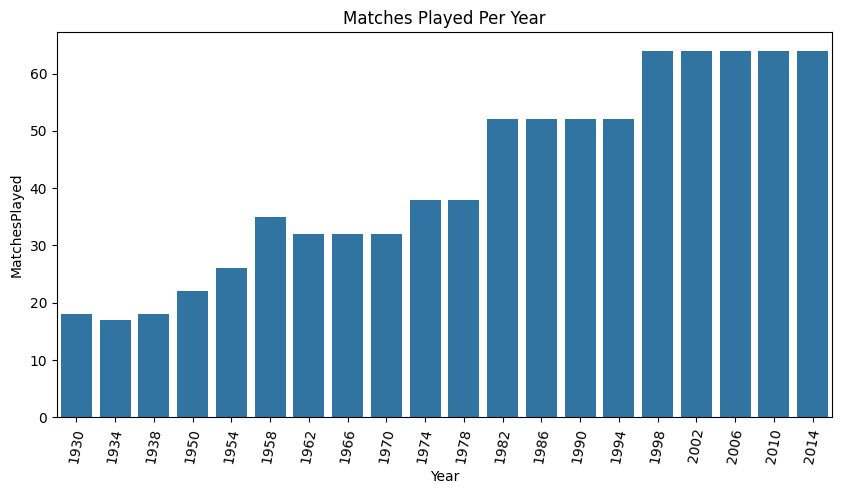

In [43]:
# Matches Played Per Year
plt.figure(figsize=(10, 5))
sns.despine(right=True)
g = sns.barplot(x='Year', y='MatchesPlayed', data=world_cup)
g.set_xticklabels(g.get_xticklabels(), rotation=80)
g.set_title('Matches Played Per Year')
plt.show()

## Top Goal Scorers per Year
Find the top 5 goal-scoring teams for each World Cup.


In [44]:
home_yearly = matches.groupby(['Year', 'Home Team Name'])['Home Team Goals'].sum()
away_yearly = matches.groupby(['Year', 'Away Team Name'])['Away Team Goals'].sum()

yearly_goals = pd.concat([home_yearly, away_yearly], axis=1).fillna(0)
yearly_goals['Total Goals'] = yearly_goals['Home Team Goals'] + yearly_goals['Away Team Goals']
yearly_goals = yearly_goals.drop(columns=['Home Team Goals', 'Away Team Goals']).reset_index()
yearly_goals.columns = ['Year', 'Country', 'Goals']
yearly_goals = yearly_goals.sort_values(by=['Year', 'Goals'], ascending=[True, False])

# Top 5 for each year
top5 = yearly_goals.groupby('Year').head(5)

# stacked bar chart
plot_data = []
for team in top5['Country'].unique():
    df_team = top5[top5['Country'] == team]
    plot_data.append(go.Bar(
        x=df_team['Year'],
        y=df_team['Goals'],
        name=team
    ))

layout = go.Layout(
    barmode='stack',
    title='Top 5 Teams by Goals in Each World Cup'
)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()


## Matches with the Highest Attendance
Visualize the top 10 matches with the highest fan attendance.


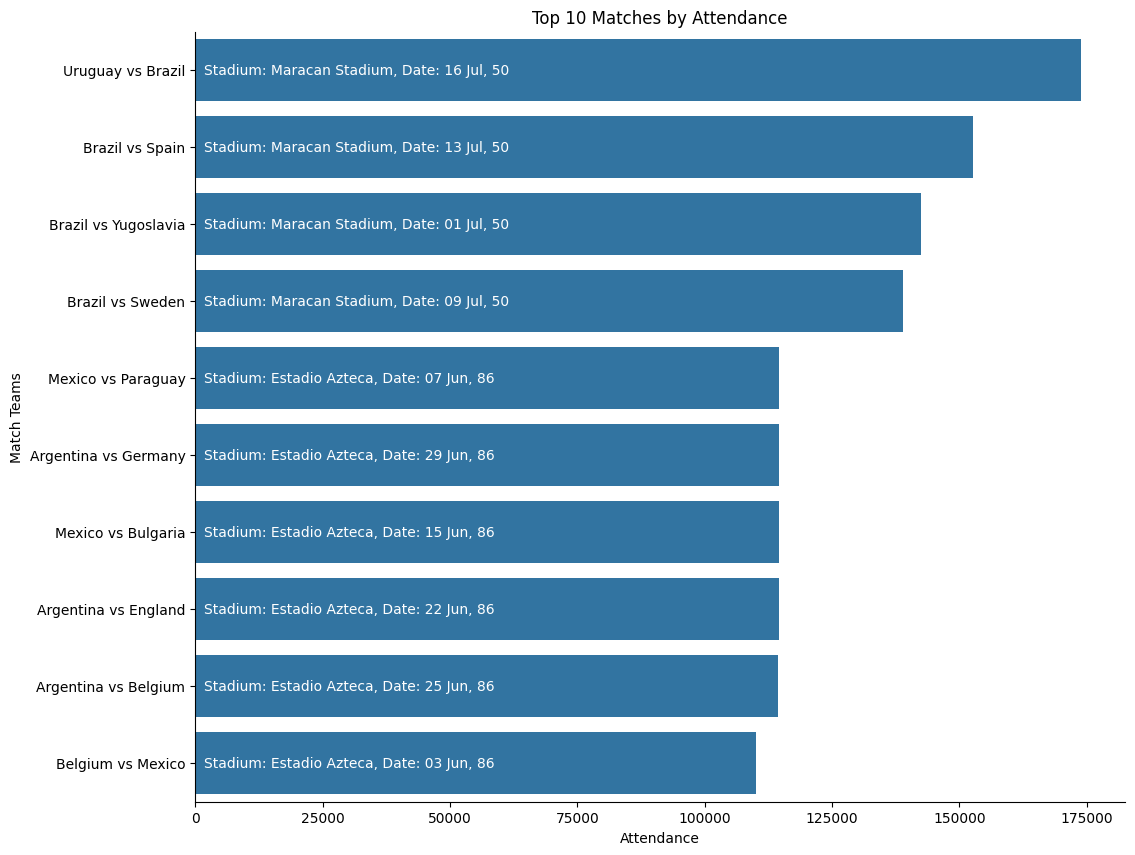

In [45]:
# Converting the 'Datetime' column to pandas datetime
matches['Datetime'] = pd.to_datetime(matches['Datetime'], errors='coerce')
matches['DateStr'] = matches['Datetime'].dt.strftime('%d %b, %y')

# top 10 by Attendance
top10_attendance = matches.sort_values(by='Attendance', ascending=False).head(10)
top10_attendance['MatchUp'] = top10_attendance['Home Team Name'] + " vs " + top10_attendance['Away Team Name']

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    y=top10_attendance['MatchUp'],
    x=top10_attendance['Attendance']
)
sns.despine(right=True)
plt.ylabel('Match Teams')
plt.xlabel('Attendance')
plt.title('Top 10 Matches by Attendance')

# Annotating each bar with stadium and date
for i, row in top10_attendance.reset_index(drop=True).iterrows():
    annotation = f"Stadium: {row['Stadium']}, Date: {row['DateStr']}"
    ax.text(
        x=0.01 * max(top10_attendance['Attendance']),  # a small offset from the left
        y=i,
        s=annotation,
        fontsize=10,
        color='white',
        va='center'
    )
plt.show()


## Medal Tally by Country
Compare how many times each country placed first, second, or third.


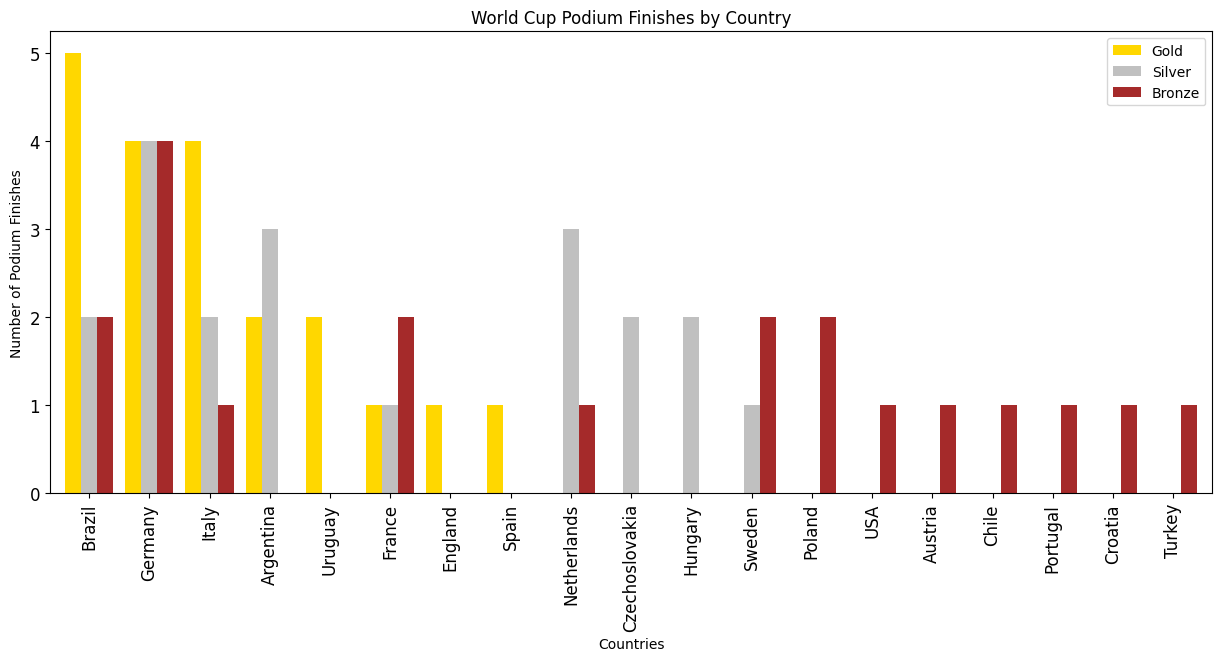

In [46]:
gold = world_cup["Winner"].value_counts().rename("Gold")
silver = world_cup["Runners-Up"].value_counts().rename("Silver")
bronze = world_cup["Third"].value_counts().rename("Bronze")

# Concatenate the three series into one DataFrame
podium_count = pd.concat([gold, silver, bronze], axis=1).fillna(0).astype(int)
podium_count = podium_count.sort_values(by=["Gold", "Silver", "Bronze"], ascending=False)

podium_count.plot(
    kind="bar",
    y=["Gold", "Silver", "Bronze"],
    color=['gold', 'silver', 'brown'],
    figsize=(15, 6),
    fontsize=12,
    width=0.8,
    align='center'
)
plt.xlabel('Countries')
plt.ylabel('Number of Podium Finishes')
plt.title('World Cup Podium Finishes by Country')
plt.show()


#  Top 10 Countries by Total Goals


/var/folders/82/3cb3k0x17r5bvwln9n1r4hh40000gn/T/ipykernel_26707/3523019913.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




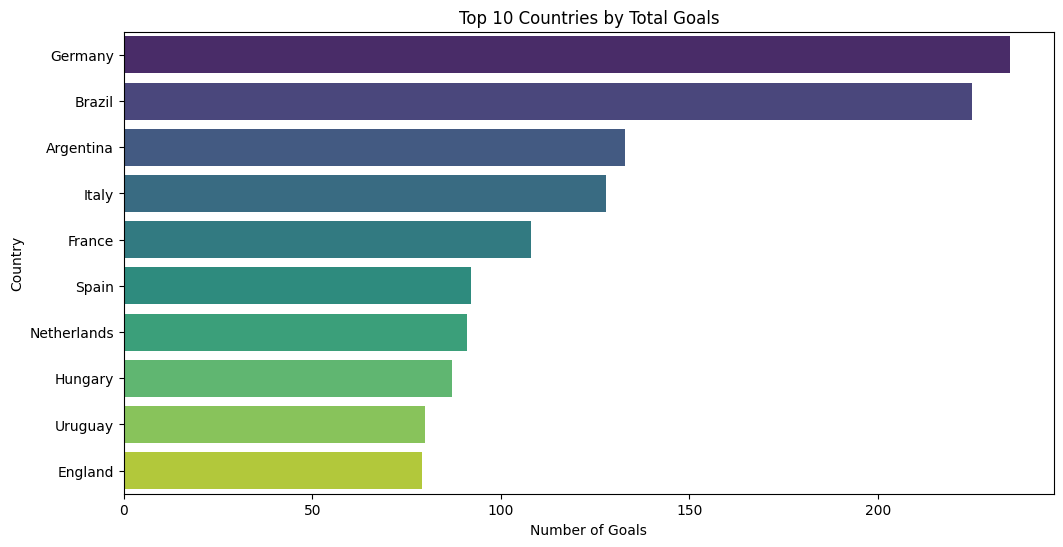

In [47]:
home = matches[['Home Team Name', 'Home Team Goals']].dropna()
away = matches[['Away Team Name', 'Away Team Goals']].dropna()

home = home.rename(columns={'Home Team Name': 'Country', 'Home Team Goals': 'Goals'})
away = away.rename(columns={'Away Team Name': 'Country', 'Away Team Goals': 'Goals'})

goal_per_country = pd.concat([home, away], ignore_index=True)
goal_per_country['Goals'] = goal_per_country['Goals'].astype(int)

goal_per_country = goal_per_country.groupby('Country')['Goals'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=goal_per_country.iloc[:10].values,
    y=goal_per_country.iloc[:10].index,
    palette='viridis'
)
plt.xlabel('Number of Goals')
plt.ylabel('Country')
plt.title('Top 10 Countries by Total Goals')
plt.show()


## Match Outcomes
Pie chart showing distribution of Home Wins, Away Wins, and Draws.


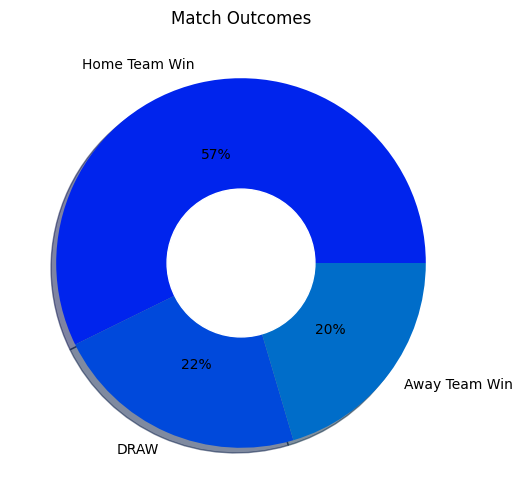

In [48]:
def get_labels(row):
    if row['Home Team Goals'] > row['Away Team Goals']:
        return 'Home Team Win'
    elif row['Home Team Goals'] < row['Away Team Goals']:
        return 'Away Team Win'
    else:
        return 'DRAW'

matches['Outcome'] = matches.apply(get_labels, axis=1)
outcome_counts = matches['Outcome'].value_counts()

plt.figure(figsize=(6, 6))
outcome_counts.plot.pie(
    autopct="%1.0f%%",
    colors=sns.color_palette('winter'),
    shadow=True
)
centre_circle = plt.Circle((0, 0), 0.4, color='white')
plt.gca().add_artist(centre_circle)
plt.title('Match Outcomes')
plt.ylabel('')
plt.show()


## Prediction Model: Random Forest
Build a machine learning model to predict whether a team will win the next World Cup.


In [49]:
def prepare_prediction_features(wc_df, matches_df):
    """
    Prepare features for prediction model with proper team encoding.
    """
    # Build performance history from World Cups (Winner, Runners-Up, Third, Fourth)
    performance = []
    for _, row in wc_df.iterrows():
        for position in ['Winner', 'Runners-Up', 'Third', 'Fourth']:
            if pd.notna(row.get(position, None)):
                performance.append({
                    'Year':       row['Year'],
                    'Team':       row[position],
                    'Position':   position,
                    'WC_Goals':   row['GoalsScored'],
                    'WC_Matches': row['MatchesPlayed']
                })
    perf_df = pd.DataFrame(performance)
    
    # Aggregate match stats (goals + avg attendance) by Year and Team
    home_stats = (
        matches_df
        .groupby(['Year', 'Home Team Name'])
        .agg({'Home Team Goals': 'sum', 'Attendance': 'mean'})
        .reset_index()
    )
    away_stats = (
        matches_df
        .groupby(['Year', 'Away Team Name'])
        .agg({'Away Team Goals': 'sum', 'Attendance': 'mean'})
        .reset_index()
    )
    home_stats.columns = ['Year', 'Team', 'Match_Goals', 'Avg_Attendance']
    away_stats.columns = ['Year', 'Team', 'Match_Goals', 'Avg_Attendance']
    
    match_stats = pd.concat([home_stats, away_stats])
    match_stats = (
        match_stats
        .groupby(['Year', 'Team'])
        .agg({'Match_Goals': 'sum', 'Avg_Attendance': 'mean'})
        .reset_index()
    )
    
    # Merge performance with match_stats
    full_df = pd.merge(perf_df, match_stats, on=['Year','Team'], how='left').fillna(0)
    
    # Create label: did this team win the next World Cup?
    full_df['Next_WC'] = full_df['Year'] + 4
    merged = pd.merge(
        full_df,
        wc_df[['Year','Winner']],
        left_on=['Next_WC','Team'],
        right_on=['Year','Winner'],
        how='left'
    )
    merged['Target'] = (~merged['Winner'].isna()).astype(int)
    
    # Drop unnecessary columns and rename Year back to Year
    return merged.drop(['Winner', 'Year_y', 'Next_WC'], axis=1).rename(columns={'Year_x':'Year'})


model_data = prepare_prediction_features(world_cup, matches)

## Model Training
Train a Random Forest classifier to predict whether a team will win the next World Cup based on previous data.


In [50]:
# Build a label encoder for every team we might see
all_teams = set(model_data['Team'].tolist()) | set(world_cup['Winner'].tolist()) | set(world_cup['Runners-Up'].tolist()) | set(world_cup['Third'].tolist())
all_teams = [team for team in all_teams if pd.notna(team)]

le = LabelEncoder()
le.fit(all_teams)

model_data['Team_Code'] = le.transform(model_data['Team'])
model_data['Position_Code'] = LabelEncoder().fit_transform(model_data['Position'])

# Select features and target
feature_cols = ['Year', 'Team_Code', 'Position_Code', 'WC_Goals', 'WC_Matches', 'Match_Goals', 'Avg_Attendance']
X = model_data[feature_cols]
y = model_data['Target']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = model.predict(X_test)
print(f"\nModel Accuracy: {accuracy_score(y_test, y_pred):.2%}")


Model Accuracy: 87.50%


## Predicting 2026 World Cup Winner
Use the trained model to rank the top 5 countries most likely to win the 2026 World Cup.



Top 5 Predicted 2026 World Cup Contenders:


,Team,Win_Probability
3,Austria,25.00%
4,Italy,21.00%
18,Hungary,16.50%
2,Chile,15.50%
15,Brazil,13.00%


/var/folders/82/3cb3k0x17r5bvwln9n1r4hh40000gn/T/ipykernel_26707/4054058718.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




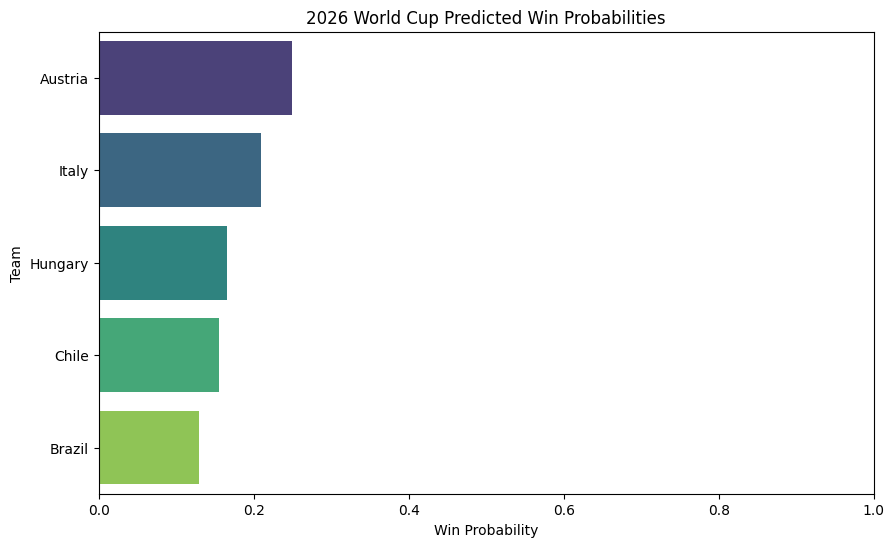


Predicted 2026 Winner: Austria (25.0% probability)


In [51]:
latest_year = world_cup['Year'].max()

predictions = []
for team in all_teams:
    team_records = model_data[model_data['Team'] == team]
    if not team_records.empty:
        latest = team_records.sort_values('Year').iloc[-1]
        wc_goals = latest['WC_Goals']
        wc_matches = latest['WC_Matches']
        match_goals = latest['Match_Goals']
        avg_att = latest['Avg_Attendance']
    else:
        # If team never appeared, used medians
        wc_goals = model_data['WC_Goals'].median()
        wc_matches = model_data['WC_Matches'].median()
        match_goals = model_data['Match_Goals'].median()
        avg_att = model_data['Avg_Attendance'].median()
    
    predictions.append({
        'Year':           latest_year,
        'Team':           team,
        'Team_Code':      le.transform([team])[0],
        'Position_Code':  0,  # (no prior position in 2026)
        'WC_Goals':       wc_goals,
        'WC_Matches':     wc_matches,
        'Match_Goals':    match_goals,
        'Avg_Attendance': avg_att
    })

pred_df = pd.DataFrame(predictions)
pred_df['Win_Probability'] = model.predict_proba(pred_df[feature_cols])[:, 1]

top_contenders = pred_df.sort_values('Win_Probability', ascending=False).head(5)

# Display the top 5 contenders
print("\nTop 5 Predicted 2026 World Cup Contenders:")
display(top_contenders[['Team', 'Win_Probability']].style.format({'Win_Probability': '{:.2%}'}))

# Barplot of probabilities
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Win_Probability',
    y='Team',
    data=top_contenders,
    palette='viridis'
)
plt.title('2026 World Cup Predicted Win Probabilities')
plt.xlabel('Win Probability')
plt.xlim(0, 1)
plt.show()

print(f"\nPredicted 2026 Winner: {top_contenders.iloc[0]['Team']} ({top_contenders.iloc[0]['Win_Probability']:.1%} probability)")
